# Test on MNIST dataset

In [44]:
%load_ext autoreload
%autoreload 2

from scripts.benchmark_functions import *
from mnist_demo.utils import *
import scod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load trained model

In [45]:
load_model_path = './best_model/mnist_model.pt'
model, optimizer, start_epoch_idx, valid_loss, criterion, device = load_model_from_ckp(load_model_path)

#### Evaluate trained model on 5 MNIST digits (drawn from mnist_test) and Fashion (drawn from fashion)

In [46]:
batch_size = 256
dataset_name = "mnist"

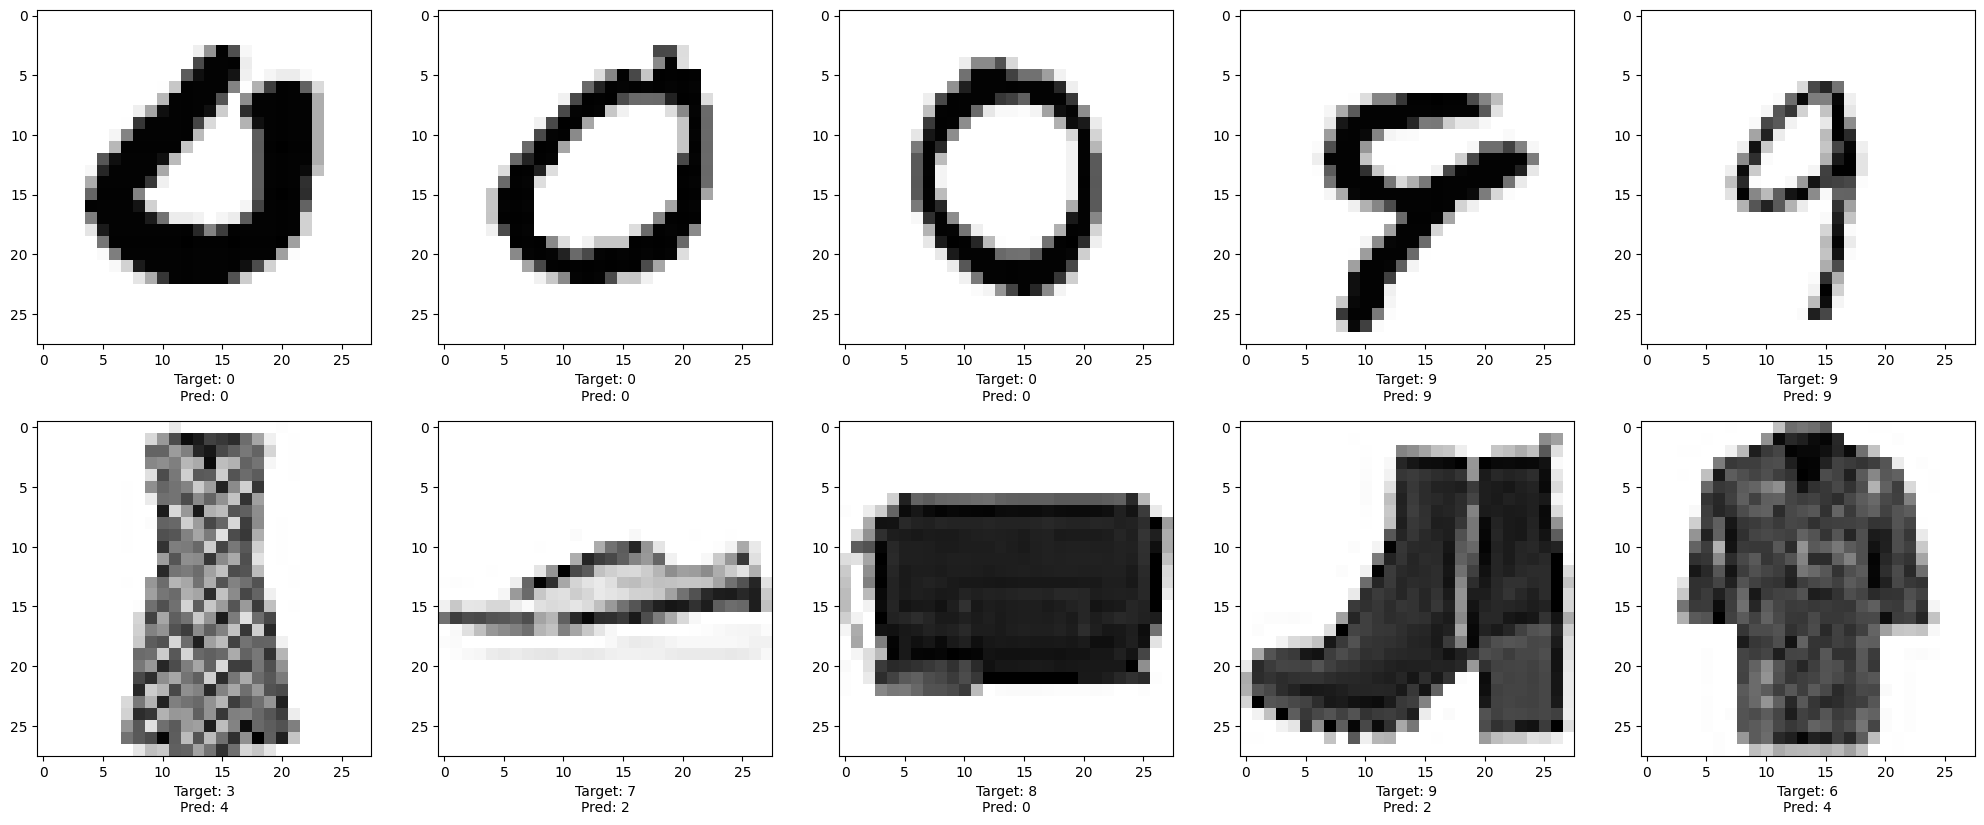

In [47]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model)

#### Add SCOD wrapper

In [48]:
unc_model = create_scod_model(load_model_path, dataset_name, batch_size)

Weight space dimension: 4.443e+04
computing basis
using T = 304


  0%|          | 0/188 [00:00<?, ?it/s]

#### Print SCOD uncertainties for MNIST digits

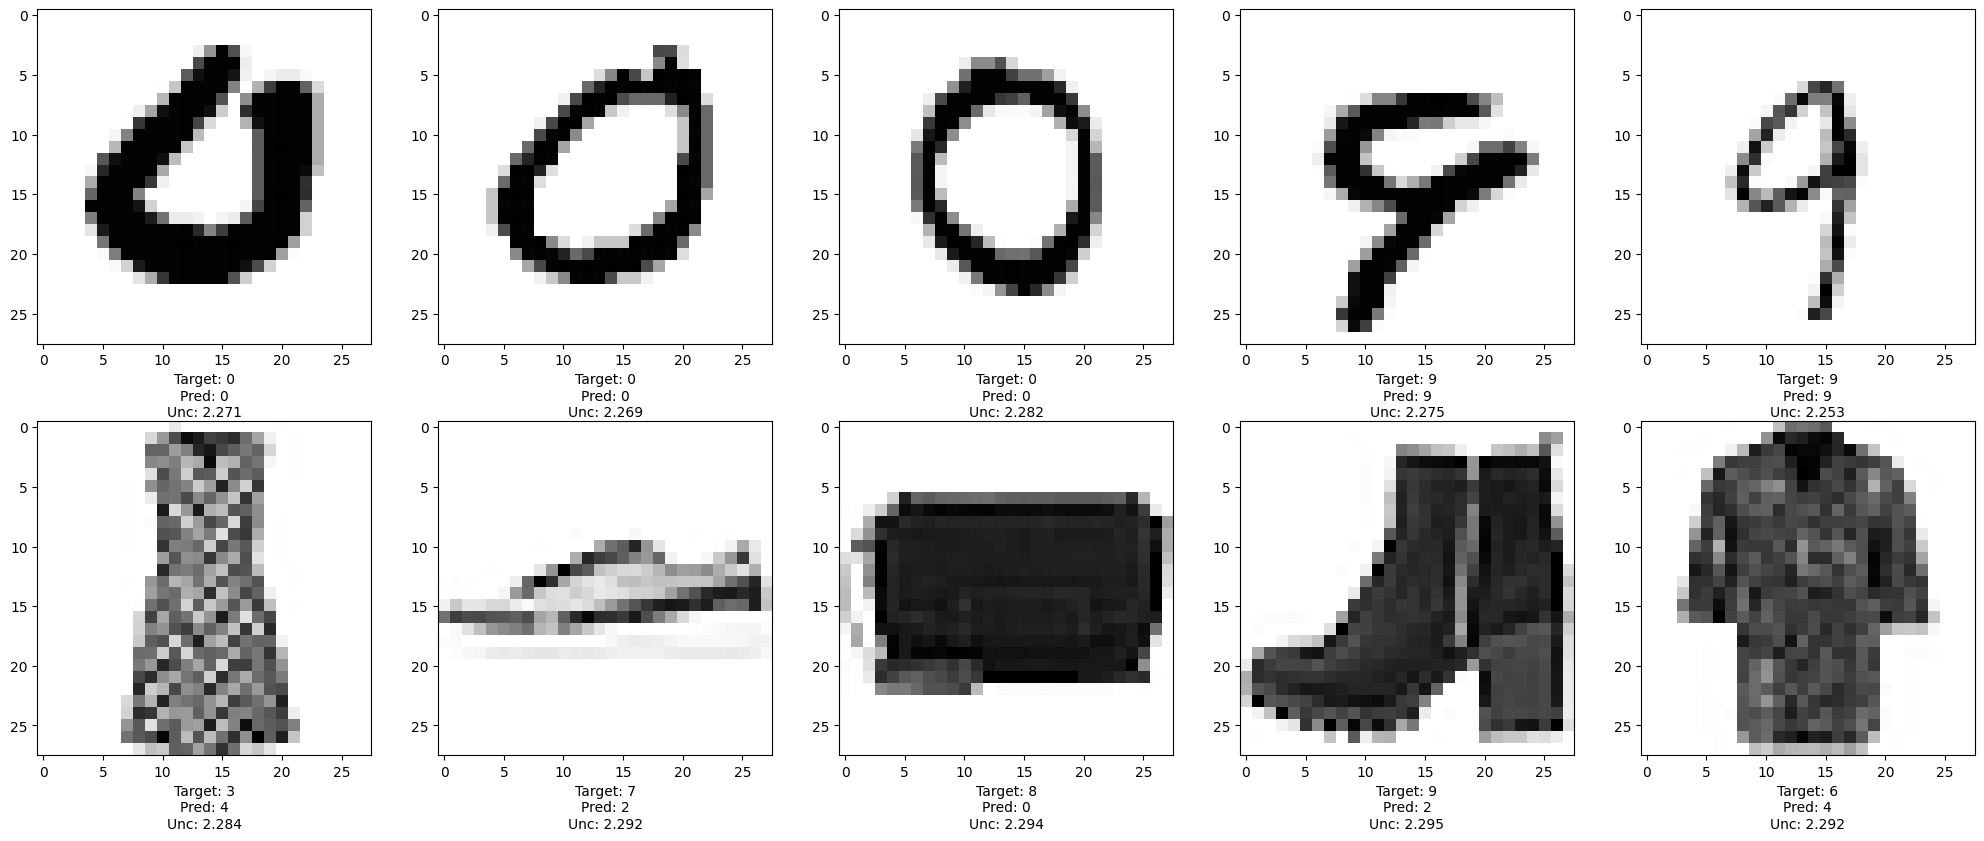

In [54]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model, unc_model=unc_model)

Question: Can SCOD detect the out-of-distribution images here?

#### ANSWER: Yes.

#### From a batch of mixed fashion + mnist, use scod-k highest and DS-SCOD to pull out 2 images to label

In [95]:
batch_size = 10
batch_compositions = [  {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5}
                        ]
# batch_compositions = [  {'mnist_test':5,'fashion':5}
#                         ]
num_batches = len(batch_compositions)

flag_limit = 2
algs_to_test = [lambda x: scod_flagger(x, unc_model, flag_limit=flag_limit, debug = False, dist_layer = scod.distributions.CategoricalLogitLayer()),
                lambda x: ds_scod_flagger(x, unc_model, flag_limit, debug=False, dist_layer = scod.distributions.CategoricalLogitLayer())]

Test seq  0  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, True, False]
Test seq  0  algorithm  1  flagged:  [False, False, False, False, False, True, False, False, True, False]
Test seq  1  algorithm  0  flagged:  [False, False, False, False, False, True, False, True, False, False]
Test seq  1  algorithm  1  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  2  algorithm  0  flagged:  [False, False, False, False, False, True, True, False, False, False]
Test seq  2  algorithm  1  flagged:  [False, False, False, False, False, True, False, False, False, True]
Test seq  3  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  3  algorithm  1  flagged:  [False, False, False, False, False, True, True, False, False, False]
Test seq  4  algorithm  0  flagged:  [False, False, False, False, False, False, True, True, False, False]
Test seq  4  algorithm  1  flagged:  [False, F

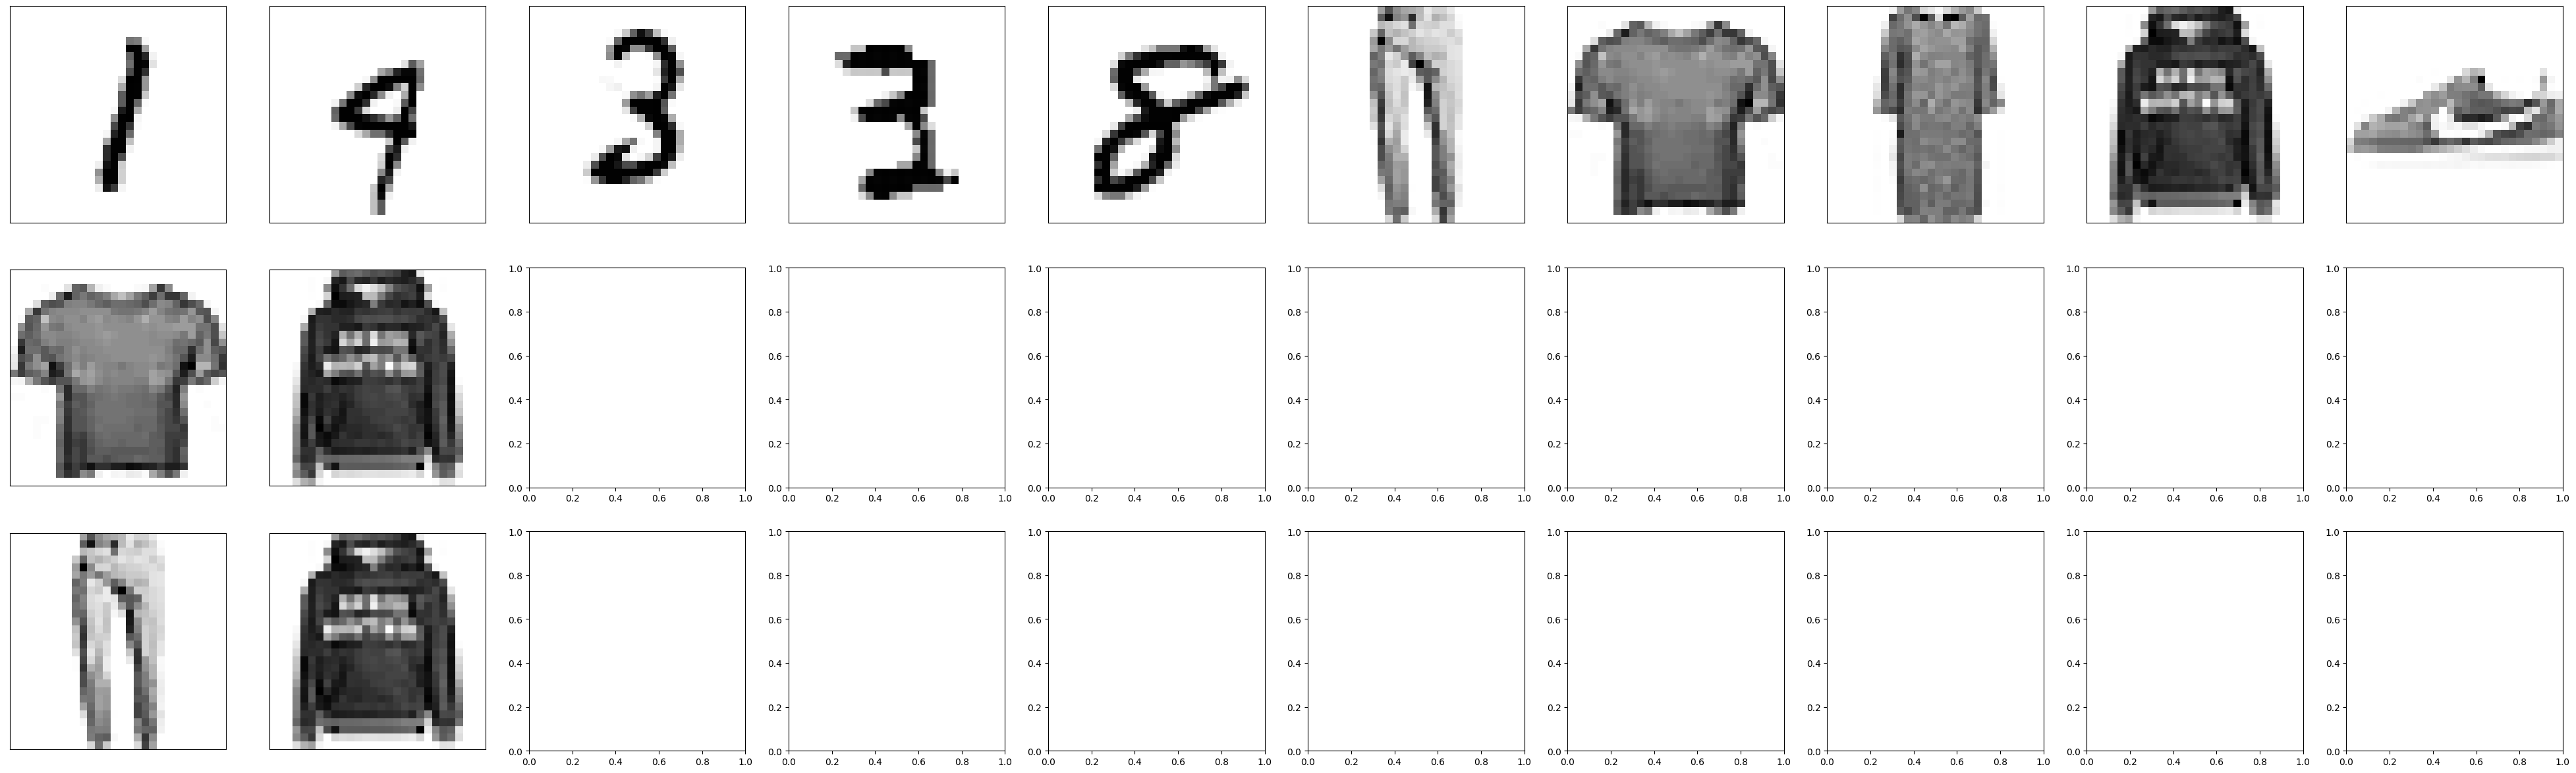

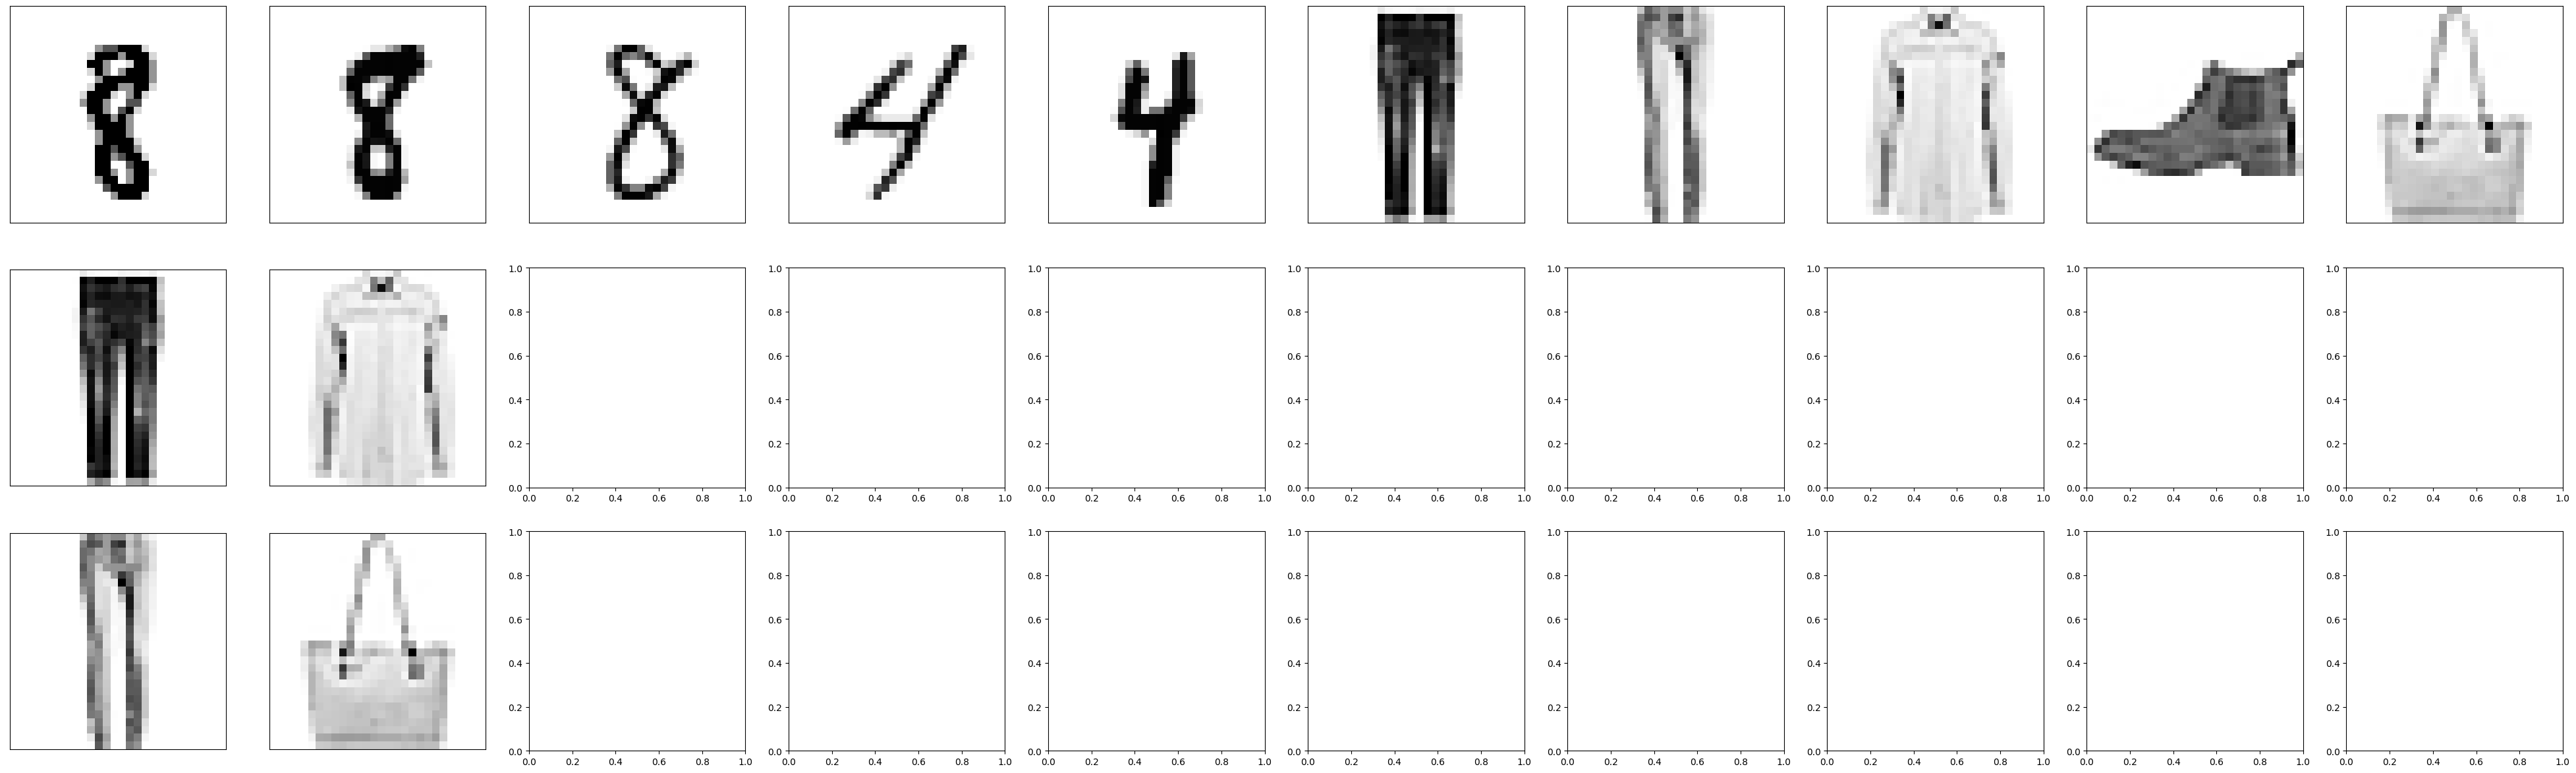

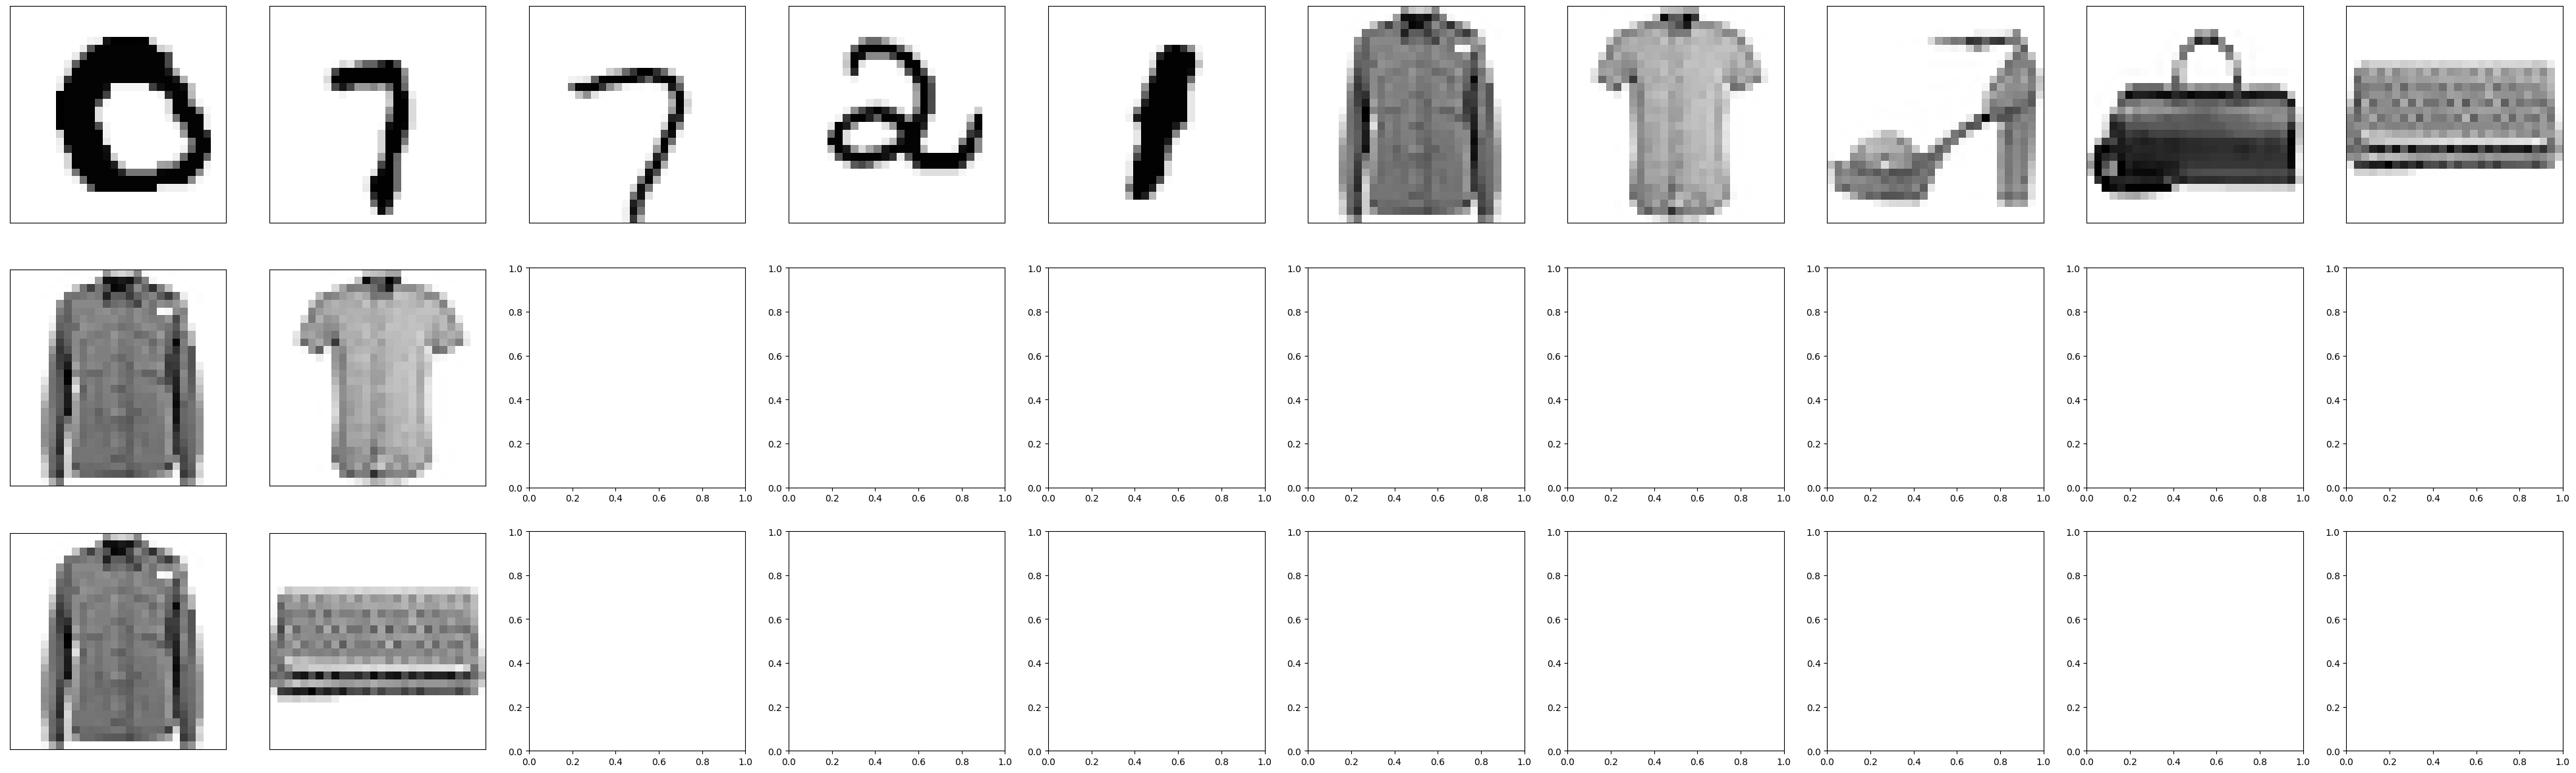

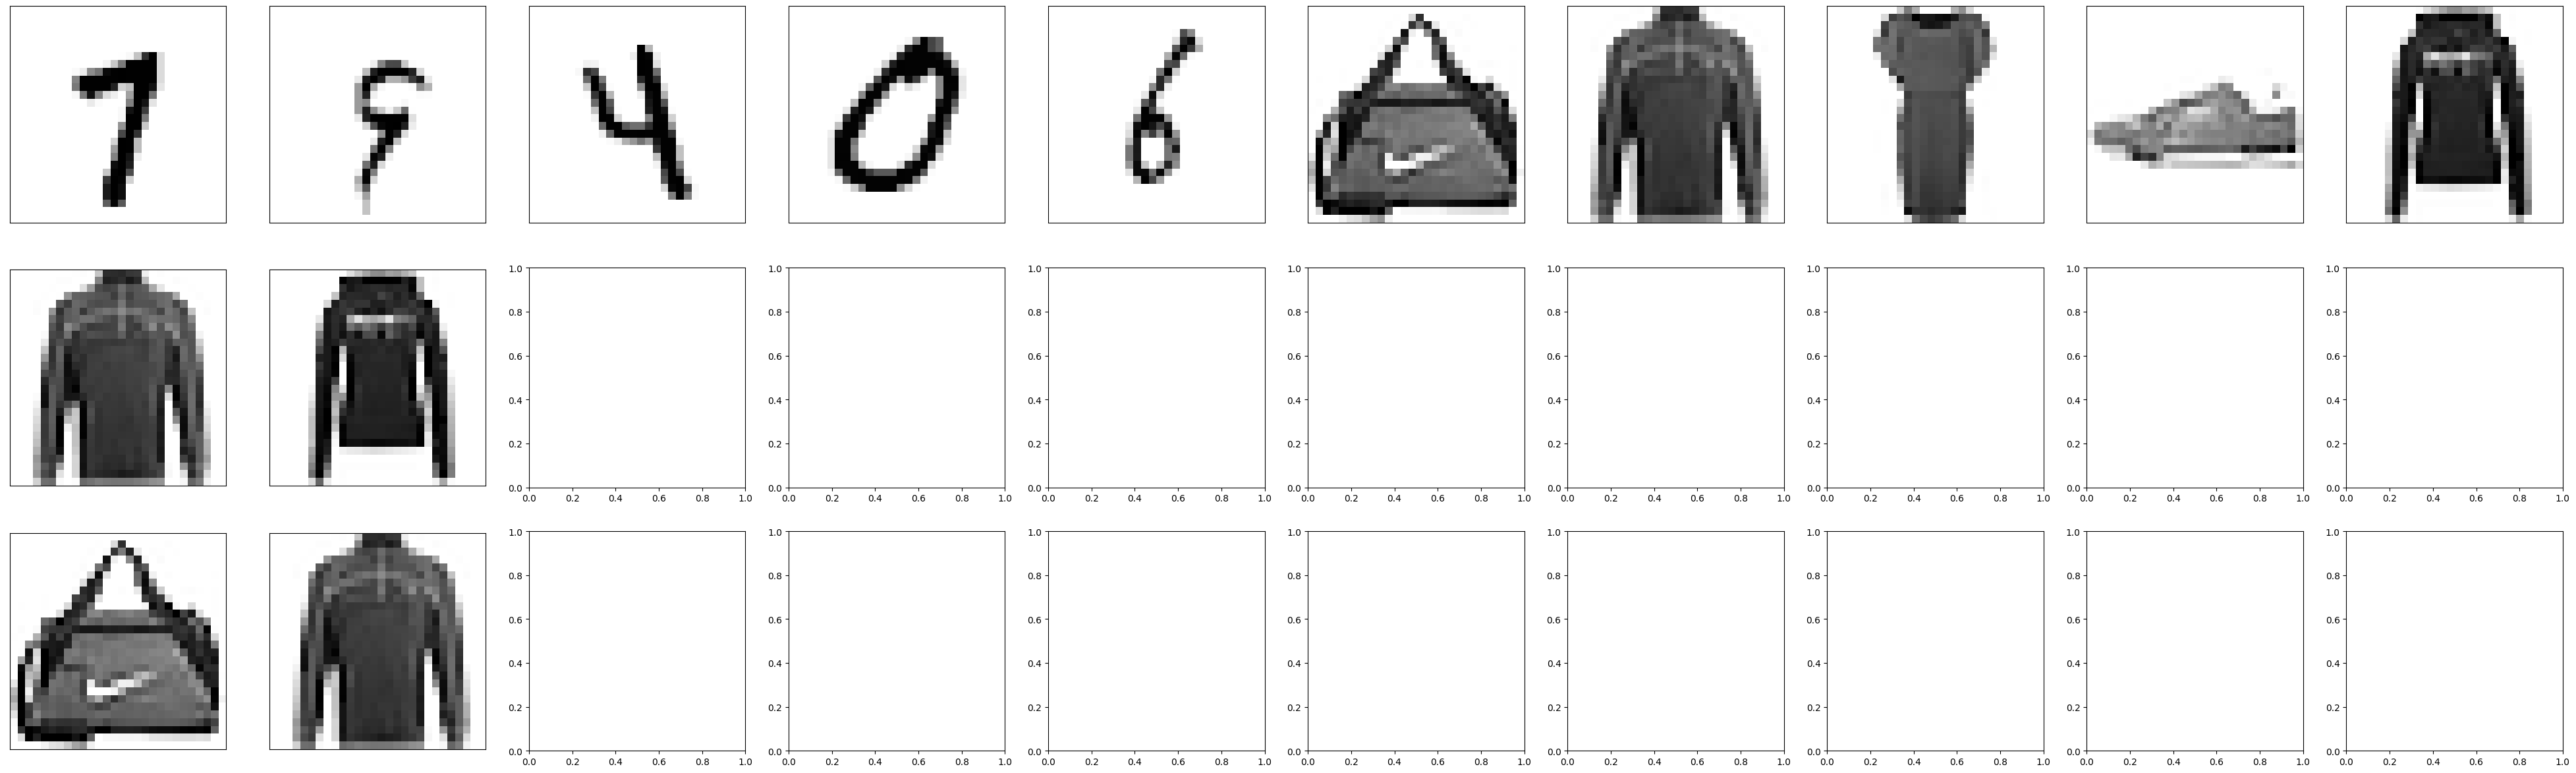

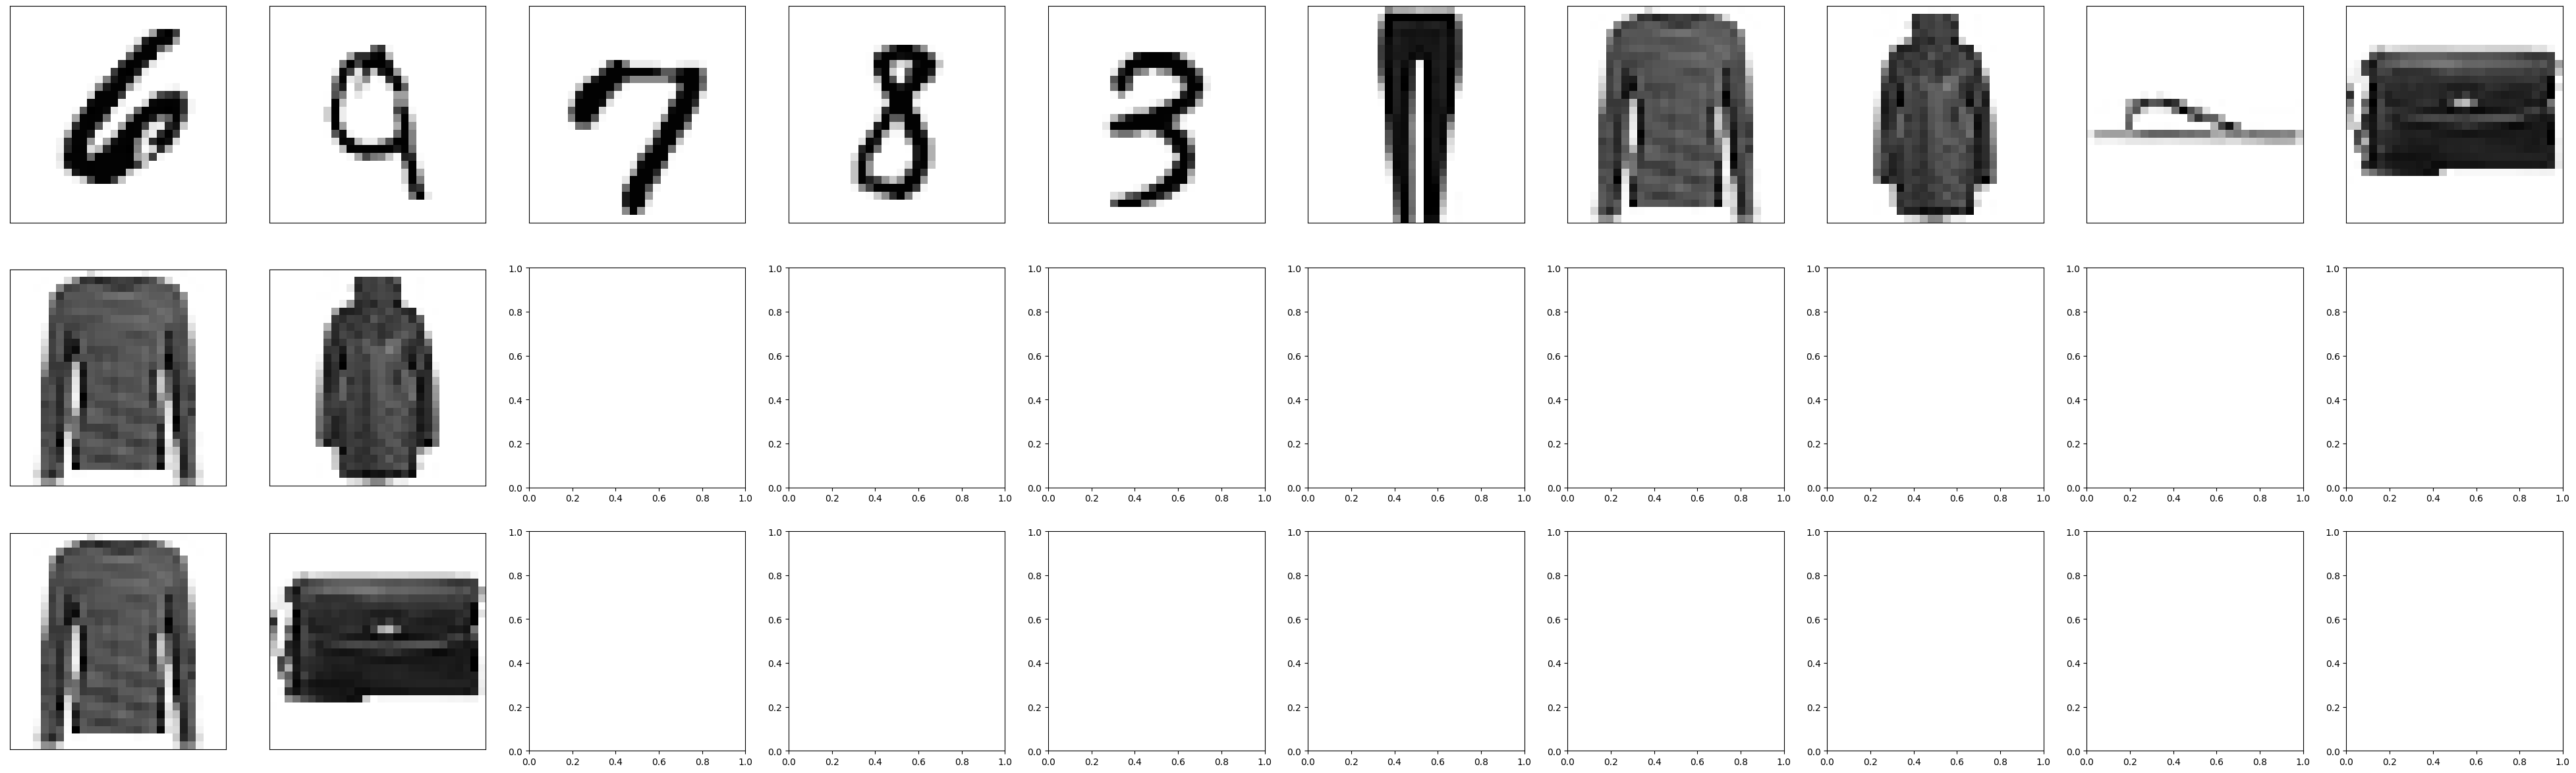

In [96]:
test_seq, labels, fnames, flags = alg_flags(algs_to_test, dataset_name, batch_size, num_batches, batch_compositions)
for i in range(num_batches):
    fig, axes = plt.subplots(len(algs_to_test)+1, batch_size, figsize=[5*batch_size, 5*(len(algs_to_test)+1)], dpi=100, squeeze=False)
    # Plot the full batch
    for j,ts in enumerate(test_seq[i]):
        plt_image(axes[0,j], ts)
    # Plot the subsampled points
    for k in range(len(algs_to_test)):
        ts_subset = [ts for (ts,flg) in zip(test_seq[i], flags[i][k]) if flg]
        for m,ts in enumerate(ts_subset):
            plt_image(axes[k+1,m], ts)



TODO:
1. From a batch, show subselection using SCOD-k highest and DS-SCOD 
1a If this doesn't show semantic diversity, try adding emnist
1b. Create figure
2. have mnist scripts and notebooks in a separate folder. Add src folder?
3. Then, see if training improves performance (accuracy) of model at all?